In [1]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#!git clone https://github.com/HNinou/MathTools_TD2
#!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

# Performing PCA on neural data


In [2]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [3]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [4]:
nb_neurons= len(dic_cont8['mat'])
nb_trials = []
for n in range(nb_neurons):
    nb_trials.append(dic_cont8['mat'][n].shape[0])
nb_trials = np.array(nb_trials)

Let's store the number of trials per neuron for each of the 8 targets

In [5]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))
for k,target in enumerate(range(1,9)):
  for n in range(nb_neurons):
    nb_trials_per_c[k, n] = dic_cont8['mat'][n][dic_cont8['target'][n]==target].shape[0]


# 1) Fill in the cell below

In [10]:
neuron_filter_ct = np.zeros(nb_neurons) == 0

for n in range(nb_neurons):
  for target in range(1,9):
    if (dic_cont8['target'][n] == target).sum() < 20 :
        neuron_filter_ct[n] = False

In [11]:
neuron_filter_ct.sum()

np.int64(245)

There are 245 neurons fulfilling this condition.

In [16]:
# put the 10 first trials in the training set and the 2 last in the testing set

X = []
for n in range(nb_neurons):
    if neuron_filter_ct[n]:
        res = []
        for target in range(1,9):
            filter_res = np.where(dic_cont8['target'][n] == target)[0][:20]
            res.append(dic_cont8['sm_mat'][n][filter_res][:,1700:1701].mean(axis = 0).flatten())

        res = np.array(res)

        X.append(res.flatten())


X = np.array(X)

X -= X.mean(axis = 1)[:,None]

In [23]:
C = X@X.T
eigval, eigvec = np.linalg.eig(C)

In [24]:
colors = np.zeros(400*8)
for target in range(8):
    colors[target:(target+1)] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec[:,-1]  @ X),
    y=(eigvec[:,-2]  @ X),
    z=(eigvec[:,-3]  @ X),
    mode='markers',
    marker=dict(size = 10,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


TypeError: Object of type complex is not JSON serializable

Variance explained by the 3 first PCs ?

In [15]:
#eigval[-1]
eigval[-3:].sum/eigval.sum() #91%.

TypeError: unsupported operand type(s) for /: 'builtin_function_or_method' and 'complex'

The 3 first PCs explain 91% of the variance.

# 2)

# 3)

The cells below formats our data to build the targets and predictors of the training and testing sets.

In [37]:
nb_trials_train = 16
nb_trials_test = 4
nb_valid_neurons = neuron_filter_ct.sum()
t_start = 1700
t_end = 1701

In [38]:
def get_XY_train_test():

    # put the 16 first trials in the training set and the 4 last in the testing set

    X_train = []
    X_test = []
    for n in range(nb_neurons):
        if neuron_filter_ct[n]:
            res_train = []
            res_test = []
            for target in range(1,9):
                #Get all indices for the current target
                target_indices = np.where(dic_cont8['target'][n] == target)[0]

                # Perform a train-test split to get 16 training and 4 testing trials
                train_indices, test_indices = train_test_split(target_indices, test_size=4, train_size=16)

                # Append the corresponding data slices for training and testing
                res_train.append(dic_cont8['sm_mat'][n][train_indices][:, t_start:t_end])
                res_test.append(dic_cont8['sm_mat'][n][test_indices][:, t_start:t_end])


            res_train = np.array(res_train)
            res_test = np.array(res_test)

            X_train.append(res_train)
            X_test.append(res_test)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train -= X_train.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]
    X_test -= X_test.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]

    X_train = X_train.swapaxes(0,2)
    X_train = X_train.swapaxes(0,1)
    X_train = X_train.reshape((8*nb_trials_train, nb_valid_neurons*(t_start-t_end)))

    X_test = X_test.swapaxes(0,2)
    X_test = X_test.swapaxes(0,1)
    X_test = X_test.reshape((8*nb_trials_test, nb_valid_neurons*(t_start-t_end)))

    Y1 = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y2 = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y_train = np.column_stack((Y1,Y2))

    Y1_test = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y2_test = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y_test = np.column_stack((Y1_test,Y2_test))

    return X_train, X_test, Y_train, Y_test


In [39]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(128, 245) (32, 245)
(128, 2) (32, 2)


# 4)

In [40]:
inv_mat = np.linalg.inv(X_train.T @ X_train)

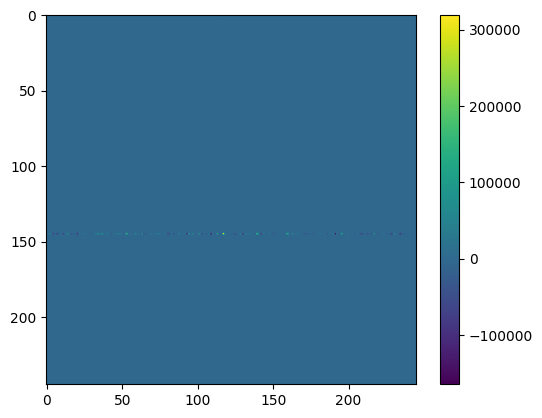

In [41]:
plt.imshow(inv_mat@(X_train.T@X_train))
plt.colorbar() #doesn't work because we should get the identity matrix but we get a weird thing

# 5)

# 6)

# 7)

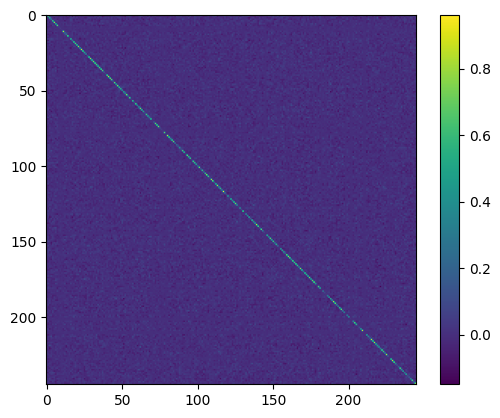

In [42]:
pinv_mat = np.linalg.pinv(X_train.T @ X_train)
plt.imshow(pinv_mat@(X_train.T@X_train))
plt.colorbar()

From now on, we will use the built in functions from scikit learn to implement our models.
The cell below builds a linear regression model with biases and fits the coefficients to the training data.

In [43]:
linreg_model = linear_model.LinearRegression(fit_intercept=True)
linreg_model.fit(X_train, Y_train)

LinearRegression()

The cell below evaluates the performance of the learned model on the test data.

In [44]:
linreg_model.score(X_test, Y_test)

0.8670938377495125

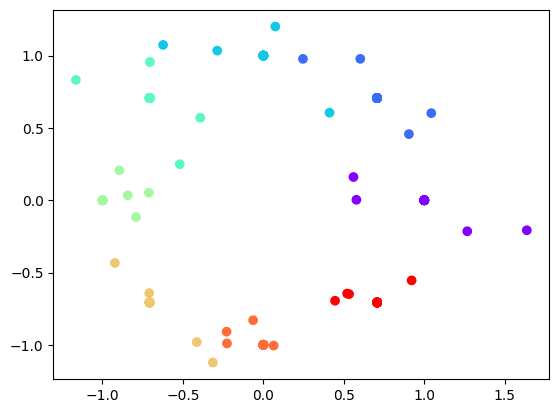

In [45]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

plt.scatter(linreg_model.predict(X_train)[:,0], linreg_model.predict(X_train)[:,1], c = colors_train, cmap = 'rainbow')
plt.scatter(linreg_model.predict(X_test)[:,0], linreg_model.predict(X_test)[:,1], c = colors_test, cmap = 'rainbow')

# 8)

# 9)

In [ ]:
score_linreg = np.zeros(100)
...
...
...

In [ ]:
score_linreg.mean()

# 10)

This can take a while

In [ ]:
score_linreg = np.zeros(100)

alpha_list = ...
score_ridge = np.zeros((100,50))
...
...
...

# 11)

In [ ]:
# Compute means and standard errors
ridge_mean = ...
ridge_sem = ... # ! this is the standard error not the STD!
linreg_mean = ...

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge vs Linear Regression")
plt.show()

# 12)

In [ ]:
opt_alpha = ...
print('optimal alpha = ', opt_alpha)

In [ ]:
X_train, X_test, Y_train, Y_test = ...
ridge_model = linear_model.Ridge(...)
ridge_model.fit(...,...)

In [ ]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

plt.scatter(...,... , c = colors_train, cmap = 'rainbow')
plt.scatter(...,... , c = colors_test, cmap = 'rainbow', marker = 'x')

# 13)

# 14)

This can take a while

In [ ]:
score_linreg = ...

alpha_list = ...
score_ridge = ...

alpha_lasso_list =...
score_lasso = ...
...
...
...

In [ ]:
opt_lasso_alpha = ...

print('optimal alpha = ', opt_lasso_alpha)

# 15)

In [ ]:
# Compute means and standard errors
ridge_mean = ...
ridge_sem = # ! this is the standard error not the STD!
lasso_mean = ...
lasso_sem = ... # ! this is the standard error not the STD!
linreg_mean = ...

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Lasso Regression with shaded error area
plt.plot(alpha_lasso_list, lasso_mean, label='Lasso Regression', color='red')
plt.fill_between(alpha_lasso_list, lasso_mean - lasso_sem, lasso_mean + lasso_sem, color='red', alpha=0.2)


# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge, Lasso and Linear Regression")
plt.show()